In [1]:
import numpy as np
import matplotlib.pyplot as plt

import mne

from mne.viz import circular_layout
from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_connectivity_circle

from mne.minimum_norm import make_inverse_operator, apply_inverse_raw, source_band_induced_power, apply_inverse_epochs,compute_source_psd, compute_source_psd_epochs

In [2]:
dic = {
'PASC001':'14741', 
'PASC003':'14744',
'PASC005':'14926',
'PASC009':'14829',
'PASC010':'s10016a',
'PASC011':'14983',
'PASC012':'14938',
'PASC013':'14824',
'PASC014':'14785',
'PASC015':'14875',
'PASC018':'14922',
'PASC019':'14880',
'PASC020':'14995',
'PASC022':'s14919',
'PASC023':'14990',
'PASC024':'15005',
'PASC025':'15028',
'PASC027':'s15076',
'PASC029':'s15256',
'PASC030':'s15162',
'PASC033':'s15185',
'PASC034':'s15248',
'PASC035':'s15304',
'PASC037':'s15503',
'PASC038':'s15359',
'PASC039':'s15459',
'PASC040':'s15473'}

In [3]:
Control_list = ["PASC001_cb_L_R_good", "PASC003_ck_R_L_good", "PASC004_tc", "PASC005_af_R_L_good", "PASC007_ee", 
                "PASC009_rg_R_L_good", "PASC010_bk_R_L_good", "PASC011_ls_R_L_good", "PASC012_kk1_R_L_good", 
                "PASC013_va_L_R_good", "PASC014_sl_L_R_good", "PASC015_rj_R_L_good", "PASC018_mm_L_R_good", 
                "PASC019_bo_L_R_good", "PASC020_lj_R_L_good", "PASC022_po_R_L_good", "PASC023_bj_R_L_good", 
                "PASC024_ko_L_R_good", "PASC025_hr_L_R_good", "PASC027_yj_R_L_good", "PASC028_kp_L_R_good", 
                "PASC029_aa_L_R_good", "PASC030_kk2_L_R_good", "PASC032_pm", "PASC033_tb_L_R_good", 
                "PASC034_mk_R_L_good", "PASC035_sk_R_L_good", "PASC036_ss", "PASC037_gr_L_R_good", 
                "PASC038_ge_R_L_good", "PASC039_fk_R_L_good", "PASC040_tj_L_R_good",  "PASC041_aa","FASC004_tk_L"]

Control_list_no_MRI = ["PASC004_tc", "PASC007_ee", "PASC032_pm", "PASC036_ss", "PASC041_aa", 'PASC028_kp_L_R_good', "FASC004_tk_L"]

len(Control_list)

34

In [4]:
stcs_all=[]
con_all=[]
for sub in Control_list:
    src_num=4
    if sub== 'PASC009_rg_R_L_good':
        num = '3'
    else:
        num = '2'

    if sub == "PASC012_kk1_R_L_good" or sub == "PASC030_kk2_L_R_good":
        val = sub[7:11]
    else:
        val = sub[7:10]
            
    spont = 'SPONT_'+num+val+'_raw_quat_tsss.fif'
    name = '/data_clean_SPONT'+num+'-raw.fif'

    if sub== "PASC004_tc" or sub == "PASC007_ee" or sub == "PASC032_pm" or sub ==  "PASC036_ss" or  sub ==  "PASC041_aa" or sub == 'PASC028_kp_L_R_good':
        
        if sub == 'PASC028_kp_L_R_good':
            data_path = '/mnt/beegfs/malann/PASC_MEG_data/'+sub
        else:
            data_path = '/mnt/beegfs/malann/PASC_MEG_data/Resting state only/'+sub
                # sample FSaverage data dir
        
        sub_name = sub[0:7]
        subjects_dir = '/mnt/beegfs/malann/mne_data/MNE-fsaverage-data'
        subject = "fsaverage"
        trans = "fsaverage"  # MNE has a built-in fsaverage transformation
        src = subjects_dir+'/'+subject+"/bem"+"/fsaverage-ico-5-src.fif"
        bem = subjects_dir+'/'+subject+"/bem"+"/fsaverage-5120-5120-5120-bem-sol.fif"
        
        # Get labels for FreeSurfer 'aparc' cortical parcellation with 34 labels/hemi
        labels_all = mne.read_labels_from_annot(subject, parc='aparc',
                                            subjects_dir=subjects_dir)
        labels_all = labels_all[:-1]
        label_colors = [label.color for label in labels_all]
  
    elif sub== "PASC001_cb_L_R_good":
        data_path = '/mnt/beegfs/malann/PASC_MEG_data/'+sub+'/1702806968/'
        sub_name = sub[0:7]
        mri_data_path = "/mnt/beegfs/malann/Freesurfer Files/Controls_BEM"
        subjects_dir = mri_data_path+'/subject'+dic[sub_name]
        subject = "sample"
        
        # Get labels for FreeSurfer 'aparc' cortical parcellation with 34 labels/hemi
        labels_all = mne.read_labels_from_annot(subject, parc='aparc',
                                            subjects_dir=subjects_dir)

    else:
        data_path = '/mnt/beegfs/malann/PASC_MEG_data/'+sub
                # Freesurfer data dir
        sub_name = sub[0:7]
        mri_data_path = "/mnt/beegfs/malann/Freesurfer Files/Controls_BEM"
        subjects_dir = mri_data_path+'/subject'+dic[sub_name]
        subject = "sample"

        # Get labels for FreeSurfer 'aparc' cortical parcellation with 34 labels/hemi
        labels_all = mne.read_labels_from_annot(subject, parc='aparc',
                                            subjects_dir=subjects_dir)
        #labels_all = labels_all[:-1]
        #labels = labels[:-1]
        label_colors = [label.color for label in labels_all]

        if sub == 'PASC019_bo_L_R_good':
            labels_all = labels_all[:-1]
        label_colors = [label.color for label in labels_all]

    raw_fname = data_path+'/'+name
    raw = mne.io.read_raw_fif(raw_fname)
    info = mne.io.read_info(raw_fname) 
    
    raw.load_data()
    raw.pick_types(meg=True)
    raw.resample(sfreq=200)
    raw.crop(tmin=15, tmax=175)       
    #raw.resample(sfreq=500)
    sfreq = raw.info['sfreq']
    
    
    # Compute Noise Covariance

    # Create ad-hoc noise covariance
    empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)
    empty_room.pick_types(meg=True)
    noise_cov = mne.compute_raw_covariance(empty_room)
    #noise_empty.plot(empty_room.info)

    
    # load forward model
    forward_sol = f"/mnt/beegfs/malann/PASC_MEG_data/Forward_files/{sub_name}_SPONT_2_ico{src_num}_raw-fwd.fif"
    fwd = mne.read_forward_solution(forward_sol)

    # Compute inverse operator
    inverse_operator = mne.minimum_norm.make_inverse_operator(
        raw.info, fwd, noise_cov, loose=0.2, depth=0.8
    )

    del fwd
   
    dur = 5
    
    onsets = np.linspace(0, raw.times[-1], num=int(raw.times[-1]/dur), endpoint=True, retstep=dur, dtype=None, axis=0)[0]
    duration = [dur]*int(raw.times[-1]/dur);
    duration = np.array(duration).T
    
    my_annotations = mne.Annotations(onset= onsets[0:-2], duration = duration[0:-2], description = 1)
    raw.set_annotations(my_annotations)
    
    events, event_dict = mne.events_from_annotations(raw)
    epochs = mne.Epochs(raw, events, baseline=(0, 0), tmin = 0, tmax= 5)
    epochs.drop_bad()
    epochs = epochs.drop(list(range(32,len(epochs))))
    
    # Compute inverse solution and for each epoch. By using "return_generator=True"
    # stcs will be a generator object instead of a list.
    snr = 3.0  # use lower SNR for single epochs
    lambda2 = 1.0 / snr ** 2
    method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)
    stcs = apply_inverse_epochs(epochs, inverse_operator, lambda2, method,
                                pick_ori="normal")
    
    src = inverse_operator['src']
    
    #label_names = ['superiorfrontal-lh', "superiorfrontal-rh", "superiorparietal-lh", "superiorparietal-rh"]
    #labels=[]
    #for lb in labels_all:
    #    if lb.name in label_names:
    #        labels.append(lb)
        
    label_ts = mne.extract_label_time_course(
    stcs, labels_all, src, mode='mean_flip', return_generator=True)
    
    fmin = 8.
    fmax = 12.
    sfreq = raw.info['sfreq']  # the sampling frequency
    con_methods = ['pli', 'wpli2_debiased', 'ciplv']
    con_method= 'wpli2_debiased'
    
    con = spectral_connectivity_epochs(
        label_ts, method= con_method, mode='multitaper', sfreq=sfreq, fmin=fmin,
        fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)

    np.save(f'/mnt/beegfs/malann/Connectivity_Control/{sub}_alpha_con_{con_method}.npy', np.array(con.get_data(output='dense')[:, :, 0]))
    con_all.append(con)


Reading labels from parcellation...
   read 34 labels from /mnt/beegfs/malann/Freesurfer Files/Controls_BEM/subject14741/sample/label/lh.aparc.annot
   read 34 labels from /mnt/beegfs/malann/Freesurfer Files/Controls_BEM/subject14741/sample/label/rh.aparc.annot
Opening raw data file /mnt/beegfs/malann/PASC_MEG_data/PASC001_cb_L_R_good/1702806968///data_clean_SPONT2-raw.fif...
    Range : 33000 ... 938999 =      6.600 ...   187.800 secs
Ready.
Reading 0 ... 905999  =      0.000 ...   181.200 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Opening raw data file /mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif...
Isotrak not found
    Read a total of 13 projection items:
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        generated with dossp-2.1 (1 x 306)  idle
        gen

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC001_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5124 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 7.22473
    scaling factor to adjust the trace = 3.46724e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC003_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5123 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 67). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 67). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 7.20409
    scaling factor to adjust the trace = 5.24053e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC004_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5124 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 6.64378
    scaling factor to adjust the trace = 4.77529e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC005_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5121 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 66). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 66). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 7.04245
    scaling factor to adjust the trace = 2.75955e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC007_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5124 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 68). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 68). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 6.78655
    scaling factor to adjust the trace = 2.17019e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC009_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5123 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 65). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 65). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 7.373
    scaling factor to adjust the trace = 5.45054e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 30

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC010_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5119 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 68). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 68). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 6.44387
    scaling factor to adjust the trace = 3.6375e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 3

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC011_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5124 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 69). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 69). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 7.70595
    scaling factor to adjust the trace = 1.54679e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC012_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5124 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 71). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 71). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 7.49942
    scaling factor to adjust the trace = 2.13108e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC013_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5124 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 69). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 69). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 7.87869
    scaling factor to adjust the trace = 2.07891e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC014_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5119 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 8.55906
    scaling factor to adjust the trace = 3.08885e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC015_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5124 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 69). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 69). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 7.91078
    scaling factor to adjust the trace = 4.23139e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC018_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5123 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 7.35646
    scaling factor to adjust the trace = 3.01749e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC019_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5121 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 67). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 67). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 7.64036
    scaling factor to adjust the trace = 1.99056e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC020_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5110 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 68). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 68). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 6.83187
    scaling factor to adjust the trace = 3.26565e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC022_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5123 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 69). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 69). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 6.61851
    scaling factor to adjust the trace = 3.32704e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC023_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5112 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 7.57951
    scaling factor to adjust the trace = 3.96333e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC024_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5123 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 68). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 68). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 6.68785
    scaling factor to adjust the trace = 3.23705e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC025_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5123 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 67). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 67). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 7.10381
    scaling factor to adjust the trace = 3.73487e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC027_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5123 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 69). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 69). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 6.87027
    scaling factor to adjust the trace = 3.28943e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC028_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5124 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 68). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 68). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 6.84664
    scaling factor to adjust the trace = 4.16952e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC029_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5124 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 69). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 69). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 7.14377
    scaling factor to adjust the trace = 2.64699e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC030_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5124 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 71). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 71). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 6.42239
    scaling factor to adjust the trace = 3.57935e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC032_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5124 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 6.16422
    scaling factor to adjust the trace = 2.88844e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC033_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5123 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 6.89181
    scaling factor to adjust the trace = 2.298e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 30

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC034_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5110 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 69). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 69). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 6.53925
    scaling factor to adjust the trace = 2.89828e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC035_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5124 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 71). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 71). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 6.51547
    scaling factor to adjust the trace = 1.48304e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC036_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5124 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 72). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 72). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 5.80314
    scaling factor to adjust the trace = 6.49334e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 30
Processing epoch : 2 / 30
Processing epoch : 3 / 30
Processing epoch : 4 / 30
Processing epoch : 5 / 30
Processing epoch : 6 / 30

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC037_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5123 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 69). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 69). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 6.98435
    scaling factor to adjust the trace = 2.4863e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 30
Processing epoch : 2 / 30
Processing epoch : 3 / 30
Processing epoch : 4 / 30
Processing epoch : 5 / 30
Processing epoch : 6 / 30


/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC038_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5122 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 6.27379
    scaling factor to adjust the trace = 2.65558e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 30
Processing epoch : 2 / 30
Processing epoch : 3 / 30
Processing epoch : 4 / 30
Processing epoch : 5 / 30
Processing epoch : 6 / 30

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC039_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5124 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 6.90511
    scaling factor to adjust the trace = 1.72322e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 30
Processing epoch : 2 / 30
Processing epoch : 3 / 30
Processing epoch : 4 / 30
Processing epoch : 5 / 30
Processing epoch : 6 / 30

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC040_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5123 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 69). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 69). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 7.48792
    scaling factor to adjust the trace = 2.98808e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 30
Processing epoch : 2 / 30
Processing epoch : 3 / 30
Processing epoch : 4 / 30
Processing epoch : 5 / 30
Processing epoch : 6 / 30

/tmp/ipykernel_3799990/3502490380.py:84: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  empty_room = mne.io.read_raw_fif('/mnt/beegfs/malann/PASC_MEG_data/empty room 03212025/data_clean_SPONT2-raw.fif', allow_maxshield=True)


Number of samples used : 902000
[done]
Reading forward solution from /mnt/beegfs/malann/PASC_MEG_data/Forward_files/PASC041_SPONT_2_ico4_raw-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (5124 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204

/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 71). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(
/tmp/ipykernel_3799990/3502490380.py:95: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (293 > 71). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = mne.minimum_norm.make_inverse_operator(


    largest singular value = 5.92858
    scaling factor to adjust the trace = 4.63377e+19 (nchan = 306 nzero = 13)
Used Annotations descriptions: ['1']
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1001 original time points ...
0 bad epochs dropped
Dropped 0 epochs: 
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 293 (13 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 30
Processing epoch : 2 / 30
Processing epoch : 3 / 30
Processing epoch : 4 / 30
Processing epoch : 5 / 30
Processing epoch : 6 / 30

In [5]:
len(labels_all)

68

Load Conectivity Matrix

In [23]:
subjects_dir = '/mnt/beegfs/malann/mne_data/MNE-fsaverage-data'
subject = "fsaverage"
trans = "fsaverage"  # MNE has a built-in fsaverage transformation
src = subjects_dir+'/'+subject+"/bem"+"/fsaverage-ico-5-src.fif"
bem = subjects_dir+'/'+subject+"/bem"+"/fsaverage-5120-5120-5120-bem-sol.fif"

con_list = []
con_method= 'wpli2_debiased'

for sub in Control_list:
    con_dir ='/mnt/beegfs/malann/Connectivity_Control/'
    Con_fname = f'{con_dir}{sub}_alpha_con_{con_method}.npy'
    con = np.load(Con_fname)
    
    con_list.append(list(con))
    print(con)

con_sum = np.sum(np.array(con_list),0)
con_avg = con_sum/len(Control_list)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.14769818  0.          0.         ...  0.          0.
   0.        ]
 [-0.00983553  0.01815526  0.         ...  0.          0.
   0.        ]
 ...
 [ 0.07854524  0.03200295  0.0271843  ...  0.          0.
   0.        ]
 [ 0.00552708 -0.03628888  0.00844732 ...  0.06214891  0.
   0.        ]
 [-0.0114714  -0.01738255  0.00064401 ... -0.03441637 -0.04859585
   0.        ]]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.02111961  0.          0.         ...  0.          0.
   0.        ]
 [-0.01503836 -0.03542358  0.         ...  0.          0.
   0.        ]
 ...
 [-0.0221358  -0.00182277 -0.01619526 ...  0.          0.
   0.        ]
 [ 0.03681517 -0.04552843  0.0803464  ...  0.13901219  0.
   0.        ]
 [ 0.02836632  0.01816741  0.11681006 ...  0.04091227 -0.0448381
   0.        ]]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.05247286  0.       

In [24]:
con_avg

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.08446644, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.10440754, 0.1222484 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.09274667, 0.07478936, 0.05335808, ..., 0.        , 0.        ,
        0.        ],
       [0.11550458, 0.11139428, 0.12099255, ..., 0.11289516, 0.        ,
        0.        ],
       [0.05144514, 0.14063486, 0.08456515, ..., 0.10234464, 0.06907846,
        0.        ]])

Reading labels from parcellation...
   read 35 labels from /mnt/beegfs/malann/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 34 labels from /mnt/beegfs/malann/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot


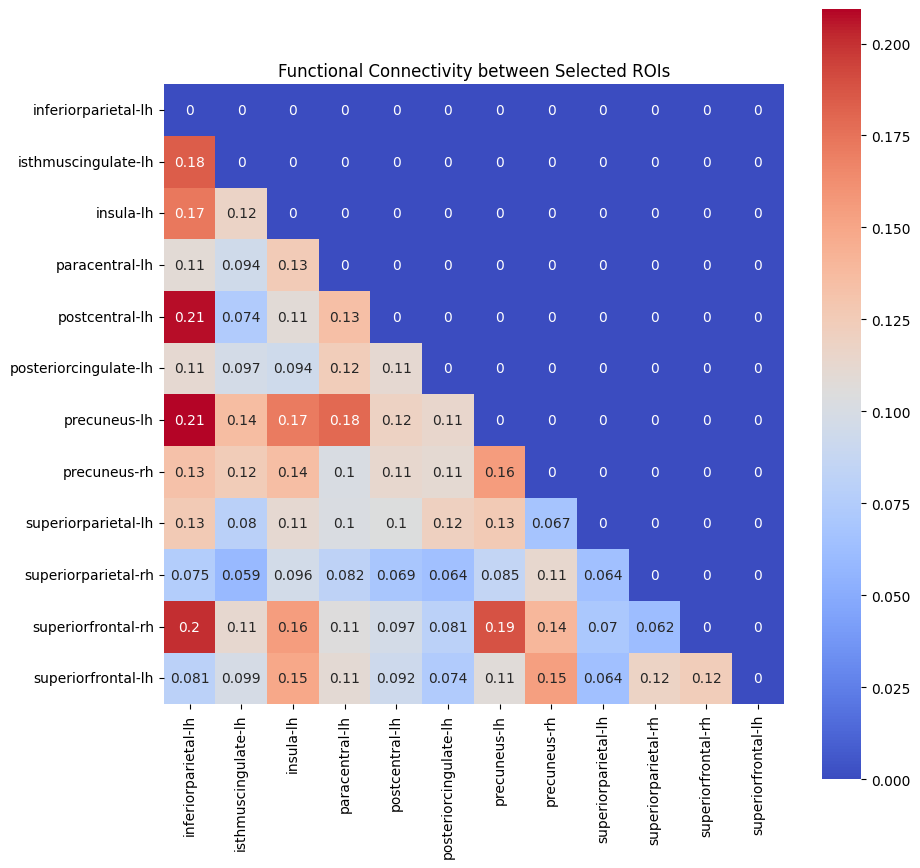

In [25]:
# List of label names for which FC will be plotted
import seaborn as sns

subjects_dir = '/mnt/beegfs/malann/mne_data/MNE-fsaverage-data'
subject = "fsaverage"
trans = "fsaverage"  # MNE has a built-in fsaverage transformation
src = subjects_dir+'/'+subject+"/bem"+"/fsaverage-ico-5-src.fif"
bem = subjects_dir+'/'+subject+"/bem"+"/fsaverage-5120-5120-5120-bem-sol.fif"


#superior parietal (SP), paracentral, postcentral, posterior cingulate, precuneus (PreC) in both hemispheres, 

#inferior parietal, precentral regions in the left hemisphere.

#Left hemisphere: superior frontal, lateral orbitofrontal, medial orbitofrontal, frontal pole, rostral middle frontal.


label_names = [
    'inferiorparietal-lh', 'precentral-lh', 
    'paracentral-lh', 'postcentral-lh', 'paracentral-rh', 'postcentral-rh', 'posteriorcingulate-lh', 'posteriorcingulate-rh',
    'precuneus-lh', 'precuneus-rh', 'superiorparietal-lh', 'superiorparietal-rh',    
    'superiorfrontal-lh', 'lateralorbitofrontal-lh', 'medialorbitofrontal-lh', 'frontalpole-lh', 'rostralmiddlefrontal-lh']


# Get the indices of the selected labels from labels_all
labels_all = mne.read_labels_from_annot(subject='fsaverage', parc='aparc', subjects_dir=subjects_dir)
label_indices = [i for i, lb in enumerate(labels_all) if lb.name in label_names]

# Extract the submatrix from con_avg (FC matrix) corresponding to these labels
con_submatrix = con_avg[np.ix_(label_indices, label_indices)]

# Plot the connectivity matrix (heatmap)
plt.figure(figsize=(10, 10))
sns.heatmap(con_submatrix, annot=True, cmap='coolwarm', xticklabels=label_names, yticklabels=label_names, square=True)
plt.title('Functional Connectivity between Selected ROIs')
plt.show()
